### Transformer in Text Classification

* Implementazione di alcuni layer custom in Keras per
poter costruire una rete neurale artificiale basata
sull'architettura **Transformer**.
* Salvataggio dell'addestramento e recupero pesi di un
modello precedentemente addestrato.


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Implementazione di un blocco Transformer
# tramite estensione della classe Layer di Keras

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.5):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-8)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-8)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [3]:
# Implementazione del blocco Embedding
# per l'utilizzo di vettori posizionali
# insieme ai vettori di token di parole
# tramite estensione della classe Layer di Keras

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [9]:
# Creazione dataset

vocab_size = 20000  # si considera un vocabolario di 20000 parole per la
                    # costruzione dello spazio vettoriale su cui modellare
                    # i vettori rappresentanti le parole nelle frasi di input
maxlen = 200  # vengono considerate le prime 200 parole di ogni recensione
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "sequenze di addestramento")
print(len(x_test), "sequenze di validazione")

print(x_train[0])
# aggiunta di padding per rendere tutte le frasi di
# lunghezza uguale (200 parole)
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

print(x_train[0])

25000 sequenze di addestramento
25000 sequenze di validazione
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345,

In [5]:
# Implementazione di un modello di classificazione
# usando il layer custom basato sull'architettura Transformer
# creato precedentemente.
# Il layer Transformer genera un vettore per ogni
# istante temporale della sequenza di input.
# Tramite GlobalAveragePooling effettuiamo una media
# su tutti gli istanti temporali e sfruttiamo una
# rete FF per classificare gli input proposti

embed_dim = 32  # dimensioni del vettore di input
num_heads = 8  # numero di meccanismi multi-head attention
ff_dim = 16  # n° di celle dei layer FF

inputs = layers.Input(shape=(maxlen,))
x = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(ff_dim, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# verifica architettura del modello
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
token_and_position_embedding (None, 200, 32)           646400    
_________________________________________________________________
transformer_block (Transform (None, 200, 32)           34768     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0     

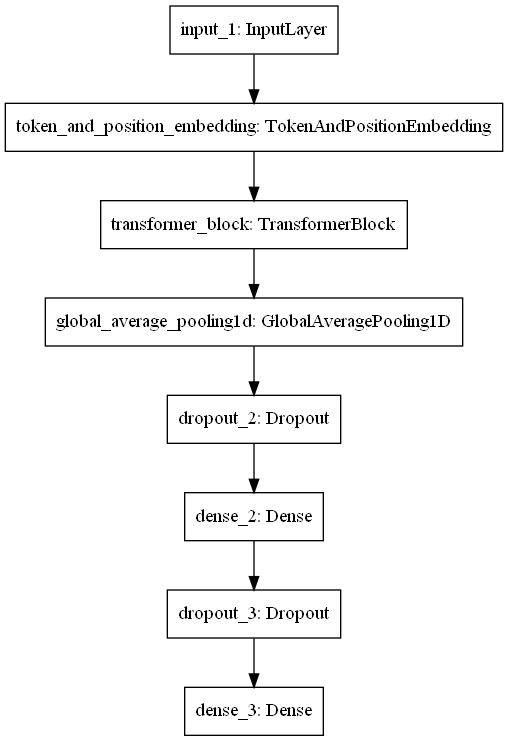

In [ ]:
# diagramma dell'architettura del modello
keras.utils.plot_model(model)

In [ ]:
# compilazione del modello
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
# addestramento
history = model.fit(
    x_train,
    y_train,
    batch_size=1024,
    epochs=5,
    validation_data=(x_test, y_test)
)

Epoch 1/5
25/25 [==============================] - 8s 236ms/step - loss: 0.7042 - accuracy: 0.5057 - val_loss: 0.6934 - val_accuracy: 0.5000

In [ ]:
# valutazione performance del modello
model.evaluate(x_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.3314 - accuracy: 0.8742

[0.33138370513916016, 0.8741599917411804]

In [ ]:
# salvataggio dati post addestramento (pesi)
# su file, per poter riutilizzare la rete
# addestrata senza doverla ri-addestrare
model.save_weights('data/weights/my_model.h5')

In [ ]:
# resettare il kernel e riavviarlo
# eseguire tutte le celle fino alla
# cella di addestramento del modello (esclusa)
# quindi continuare da qui:

# caricamento pesi modello da file
model.load_weights('data/weights/my_model.h5')

model.evaluate(x_test, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.3314 - accuracy: 0.8742

[0.33138370513916016, 0.8741599917411804]